# Experiment Pipeline

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [19]:
import os
from pathlib import Path
from configs import CONFIG_DIR
from figures import FIGURES_DIR

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from hubmap.data import DATA_DIR
from hubmap.dataset import transforms as T
from hubmap.dataset import TrainDataset, ValDataset

from hubmap.experiments.TransResUNet.utils import run
from hubmap.experiments.TransResUNet.utils import DiceBCELoss
from hubmap.experiments.TransResUNet.utils import visualize_detailed_results
from hubmap.experiments.TransResUNet.utils import visualize_detailed_results_overlay

from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.visualization import visualize_result

from hubmap.models.trans_res_u_net.model import TResUnet, TResUnet512

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class ChannelWeightedDiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, weights=torch.tensor([1, 1, 1, 1])):
        super(ChannelWeightedDiceBCELoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets, smooth=1):
        # inputs = torch.softmax(inputs, dim=1)
        w = self.weights.unsqueeze(0).repeat(inputs.size(0), 1)
        w = w.to(inputs.device)        
        inputs = torch.sigmoid(inputs)

        # inputs = inputs.reshape(-1)
        # targets = targets.reshape(-1)

        intersection = (inputs * targets).sum((-2, -1))
        dice_loss = 1 - (2.0 * intersection + smooth) / (
            inputs.sum((-2, -1)) + targets.sum((-2, -1)) + smooth
        )
        dice_loss = (dice_loss * w).mean()
        
        BCE = F.binary_cross_entropy(inputs, targets, reduction="none")
        BCE_per_channel = BCE.mean(dim=(-2, -1))
        BCE = (BCE_per_channel * w).mean()
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


In [21]:
NUM_EPOCHS = 20
BATCH_SIZE = 8
CHECKPOINT = "pretrained_resnet50_warmup_20_512"
CONTINUE_TRAINING = False
PATIENCE = 20
LR = 1e-4
BACKBONE = "resnet50"
PRETRAINED = True

# WEIGHT = torch.tensor([4, 1, 1, 2])
WEIGHT = torch.tensor([10, 1, 1, 5])

In [22]:
FIGURES_CHECKPOINT_PATH = Path(FIGURES_DIR, "TransResUNet", f"{CHECKPOINT}")
os.makedirs(FIGURES_CHECKPOINT_PATH, exist_ok=True)

In [23]:
CHECKPOINT_FILE_NAME = f"{CHECKPOINT}.pt"
CHECKPOINT_NAME = Path("TransResUNet", CHECKPOINT_FILE_NAME)
config = {
    "num_epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "checkpoint_name": CHECKPOINT_NAME,
    "patience": PATIENCE,
    "lr": LR,
    "backbone": BACKBONE,
    "pretrained": PRETRAINED,
    "figures_directory": FIGURES_CHECKPOINT_PATH,
    "weight": WEIGHT
}
os.makedirs(Path(CONFIG_DIR / CHECKPOINT_NAME).parent.resolve(), exist_ok=True)
torch.save(config, Path(CONFIG_DIR / CHECKPOINT_NAME))

In [41]:
# torchvision.transforms.ColorJitter
# 
import torchvision.transforms as TVT

train_transforms = T.Compose(
    [
        T.ToTensor(),
        # T.Resize((256, 256)),
        T.Resize((512, 512)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        # T.RandomCrop((256, 256)),
        T.RandomCrop((512, 512)),
    ]
)

val_transforms = T.Compose(
    [
        T.ToTensor(),
        # T.Resize((256, 256)),
        T.Resize((512, 512)),
    ]
)

In [42]:
train_set = TrainDataset(DATA_DIR, transform=train_transforms, with_background=True)
val_set = ValDataset(DATA_DIR, transform=val_transforms, with_background=True)

In [43]:
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=16
)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
model = TResUnet512(num_classes=4, backbone=BACKBONE, pretrained=PRETRAINED)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = ChannelWeightedDiceBCELoss(weight=WEIGHT.to(device))
# criterion = ChannelWeightedDiceBCELossSummed(weight=WEIGHT.to(device))
# lr_scheduler = LRScheduler(optimizer, patience=5)
lr_scheduler = None
early_stopping = None

result = run(
    num_epochs=NUM_EPOCHS,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    early_stopping=early_stopping,
    lr_scheduler=lr_scheduler,
    checkpoint_name=CHECKPOINT_NAME,
    continue_training=CONTINUE_TRAINING,
)

Epoch 1/20 - Summary: Train Loss: 1.2695 - Acc: 0.0265 --- Val Loss: 1.1529 - Acc: 0.0005
Epoch 2/20 - Summary: Train Loss: 1.1082 - Acc: 0.2681 --- Val Loss: 1.0361 - Acc: 0.4823
Epoch 3/20 - Summary: Train Loss: 0.9885 - Acc: 0.5440 --- Val Loss: 0.9340 - Acc: 0.5610
Epoch 4/20 - Summary: Train Loss: 0.9037 - Acc: 0.6016 --- Val Loss: 0.8604 - Acc: 0.5771
Epoch 5/20 - Summary: Train Loss: 0.8342 - Acc: 0.6384 --- Val Loss: 0.8124 - Acc: 0.6311
Epoch 6/20 - Summary: Train Loss: 0.7790 - Acc: 0.6714 --- Val Loss: 0.7634 - Acc: 0.6452
Epoch 7/20 - Summary: Train Loss: 0.7391 - Acc: 0.6764 --- Val Loss: 0.7248 - Acc: 0.6551
Epoch 8/20 - Summary: Train Loss: 0.7042 - Acc: 0.6945 --- Val Loss: 0.6986 - Acc: 0.6458
Epoch 9/20 - Summary: Train Loss: 0.6789 - Acc: 0.7040 --- Val Loss: 0.6721 - Acc: 0.7004
Epoch 10/20 - Summary: Train Loss: 0.6539 - Acc: 0.7127 --- Val Loss: 0.6609 - Acc: 0.6484
Epoch 11/20 - Summary: Train Loss: 0.6391 - Acc: 0.7142 --- Val Loss: 0.6590 - Acc: 0.6176
Epoch 12

<br>

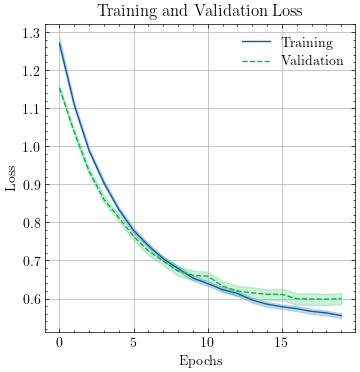

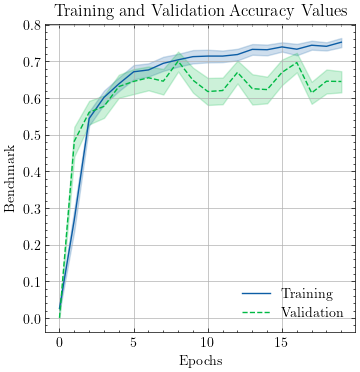

In [29]:
loss_fig, benchmark_fig = visualize_result(result)

In [ ]:
loss_fig.savefig(Path(FIGURES_CHECKPOINT_PATH, "results_loss.png"))
benchmark_fig.savefig(Path(FIGURES_CHECKPOINT_PATH, "results_accuracy.png"))

In [45]:
data = iter(val_set)

In [46]:
image, target = next(data)

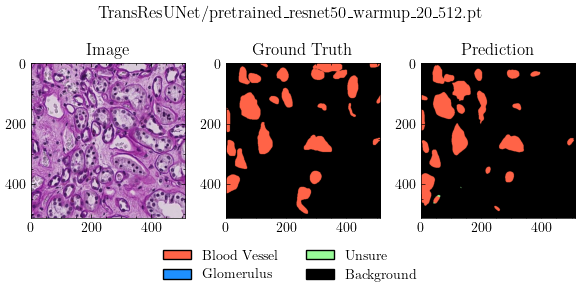

: 

In [47]:
detailed = visualize_detailed_results(model, image, target, device, CHECKPOINT_NAME)

In [ ]:
detailed.savefig(Path(FIGURES_CHECKPOINT_PATH, "example_results.png"))

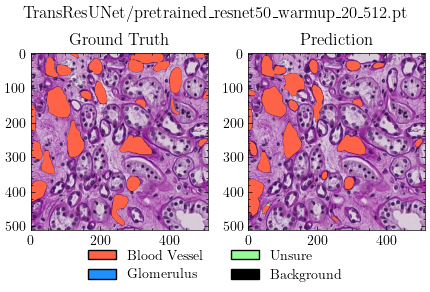

In [33]:
detailed_overlay = visualize_detailed_results_overlay(
    model, image, target, device, CHECKPOINT_NAME
)

In [ ]:
detailed_overlay.savefig(Path(FIGURES_CHECKPOINT_PATH, "example_overlay.png"))

<br>